# Using LlamaIndex as a Framework

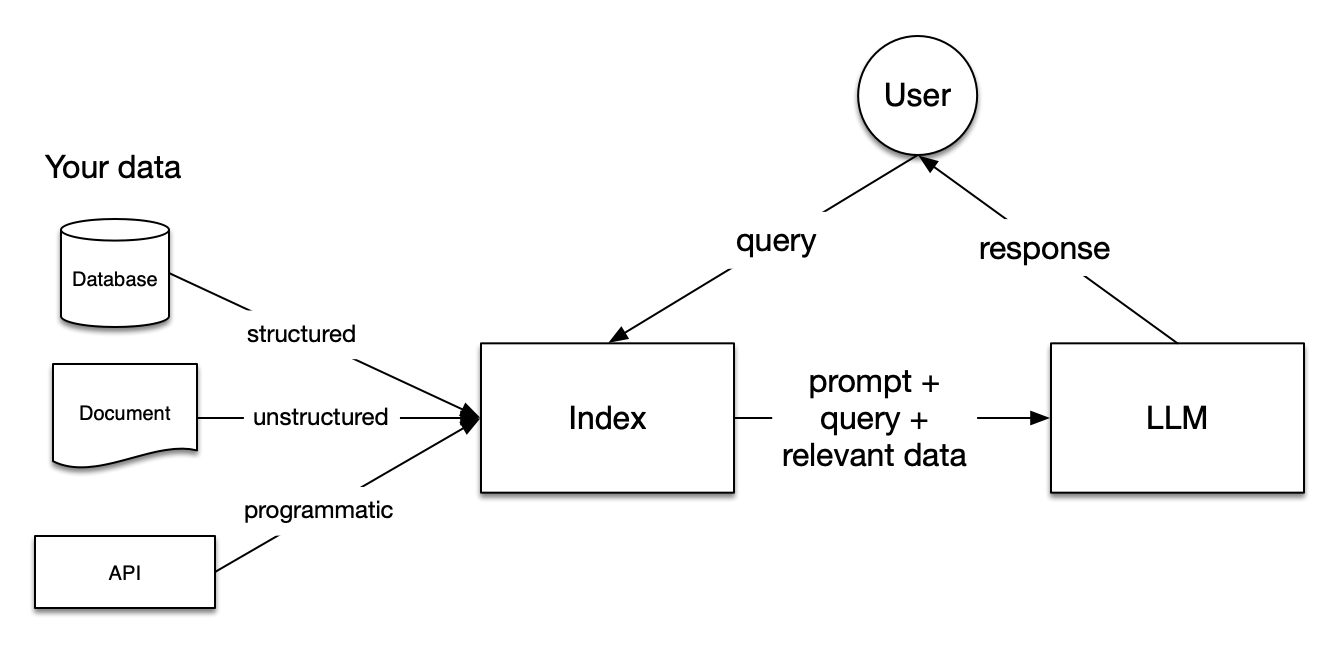

In [ ]:
# !pip install llama-index llama-index-llms-ollama

## Configuration

In [1]:
from llama_index.llms.ollama import Ollama
llm = Ollama(
        model="llama3",
        verbose=False,
    )

Embedding models take text, images, or other data and transform them into numerical representations

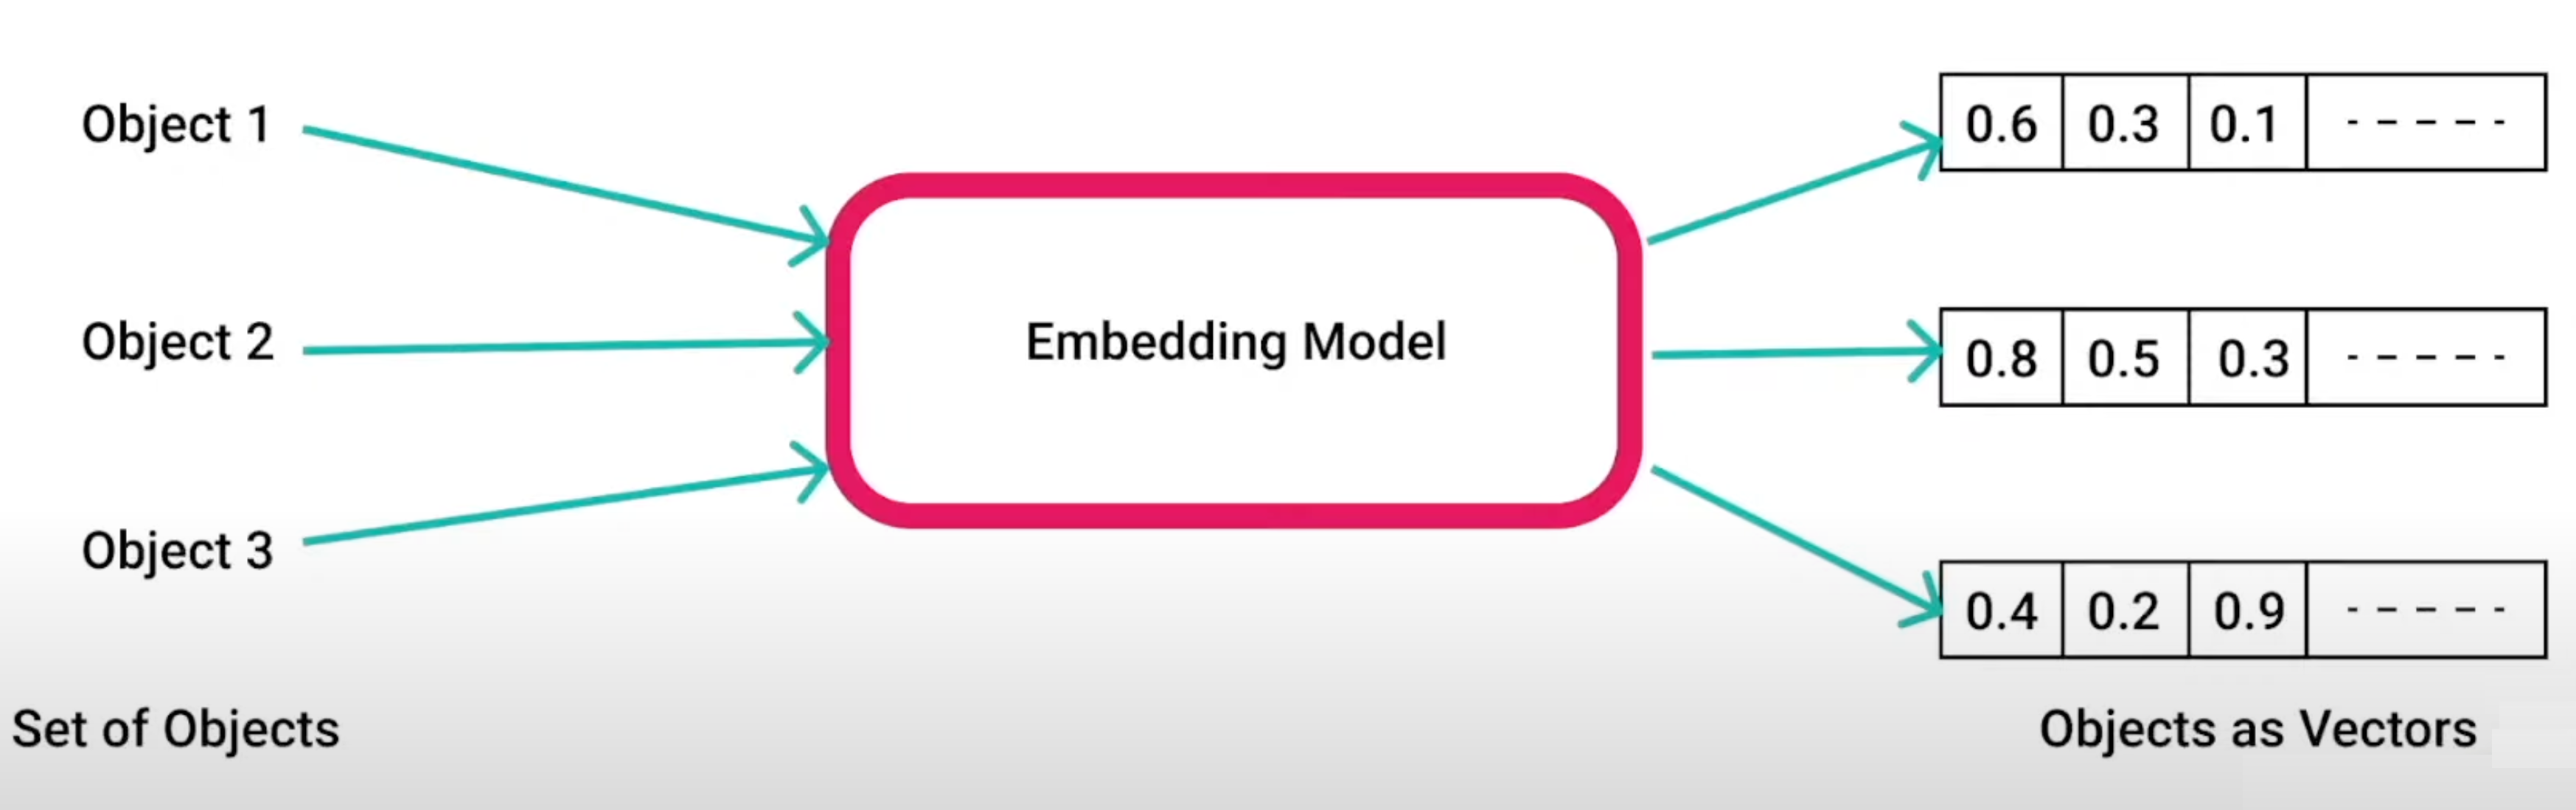

In [2]:
from llama_index.embeddings.ollama import OllamaEmbedding

embeddings = (
    OllamaEmbedding(model_name='nomic-embed-text')  
)

The Settings is a bundle of commonly used resources used during the indexing and querying stage in a LlamaIndex application.

In [5]:
from llama_index.core import Settings

Settings.llm = llm
Settings.embed_model = embeddings

## Loading

In [6]:
import os
from llama_index.core import SimpleDirectoryReader



In [7]:
march_2022 = SimpleDirectoryReader(
    input_files=["./data/uber_10q_march_2022.pdf"]
).load_data()

june_2022 = SimpleDirectoryReader(
    input_files=["./data/uber_10q_june_2022.pdf"]
).load_data()

sept_2022 = SimpleDirectoryReader(
    input_files=["./data/uber_10q_sept_2022.pdf"]
).load_data()


## Indexing

In [8]:
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings, StorageContext, load_index_from_storage

In [12]:
def _index_data(data_name, data):
    if not os.path.exists("./storage/" + data_name):
        index = VectorStoreIndex.from_documents(data)
        index.storage_context.persist(persist_dir="./storage/" + data_name)
    else:
        storage_context = StorageContext.from_defaults(persist_dir="./storage/" + data_name)
        index = load_index_from_storage(storage_context)
    return index


## Store in vectors

In [14]:
march_index = _index_data("march", march_2022)
june_index = _index_data("june", june_2022)
sept_index = _index_data("sept", sept_2022)

A query engine takes in a natural language query, and returns a rich response. Built on one or many indexes via retrievers

In [15]:
march_engine = march_index.as_query_engine(similarity_top_k=3)
june_engine = june_index.as_query_engine(similarity_top_k=3)
sept_engine = sept_index.as_query_engine(similarity_top_k=3)

Build a Router that can choose whether to do vector search or summarization

In [16]:
from llama_index.core.tools import QueryEngineTool, ToolMetadata

query_engine_tools = [
    QueryEngineTool(
        query_engine=sept_engine,
        metadata=ToolMetadata(
            name="sept_22",
            description=(
                "Provides information about Uber quarterly financials ending"
                " September 2022"
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=june_engine,
        metadata=ToolMetadata(
            name="june_22",
            description=(
                "Provides information about Uber quarterly financials ending"
                " June 2022"
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=march_engine,
        metadata=ToolMetadata(
            name="march_22",
            description=(
                "Provides information about Uber quarterly financials ending"
                " March 2022"
            ),
        ),
    ),
]

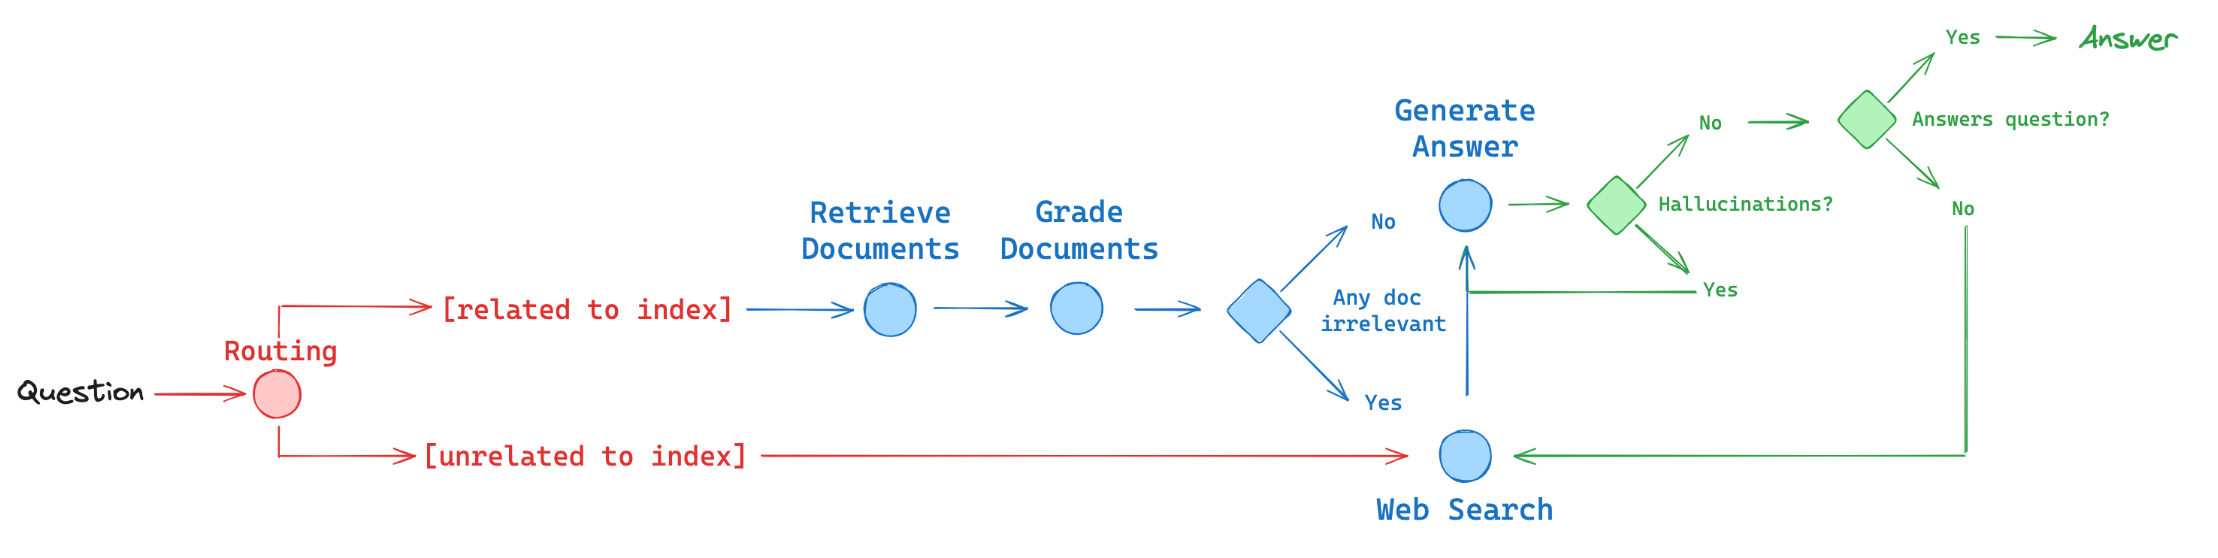

In [17]:
from llama_index.core.query_engine import RouterQueryEngine

query_engine = RouterQueryEngine.from_defaults(
    query_engine_tools, select_multi=False, verbose=True
)

In [18]:
response = query_engine.query(
    "Analyze Uber revenue in the last quarter"
)

Selecting query engine 0: The question asks about Uber revenue in the last quarter, which would be September 2022 based on the provided options..


In [19]:

print(response)

Revenue for the three months ended September 30, 2022 was $8,343 million.


In [20]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='7c5948e6-744f-4c69-aa9f-ae001f25dbc4', embedding=None, metadata={'page_label': '41', 'file_name': 'uber_10q_sept_2022.pdf', 'file_path': 'data/uber_10q_sept_2022.pdf', 'file_type': 'application/pdf', 'file_size': 1178622, 'creation_date': '2024-07-05', 'last_modified_date': '2024-07-04'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='15974ff0-b31b-4b70-8e71-00762e99ffbd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '41', 'file_name': 'uber_10q_sept_2022.pdf', 'file_path': 'data/uber_10q_sept_2022.pdf', 'file_type': 'application/pdf', 'file_size': 1178622, 'creation_date': '2024-07-05', 'last_modified_date': '2024-07-04'}, hash='65ff6a4265c226bdadb2acf7c4

In [21]:
response = query_engine.query(
    "Give me the Uber revenue difference comparing Q3 in 2021 and Q3 in 2022"
)
print(response)

Selecting query engine 0: The question asks to compare Q3 in 2021 and Q3 in 2022, so option 1 provides the most relevant information..
$8,343 - $4,845 = $3,498 million increase in revenue from Q3 2021 to Q3 2022.


In [22]:
response = query_engine.query("give me a prediction of Uber revenue for Q3 in 2023")
print(response)

Selecting query engine 0: Q2 (June) and Q3 are consecutive quarters, so the Q2 financials will provide relevant information to make an educated prediction about Q3 revenue.
Based on the historical data provided in the context, I can attempt to make an educated estimate.

The table shows significant revenue growth from 2021 to 2022, with a compound annual growth rate (CAGR) of around 25%. Assuming this trend continues, and considering the strong performance in the freight segment, I predict that Uber's revenue for Q3 in 2023 will be around $10.5 billion.

Please note that this is just an estimate based on the provided data, and actual results may vary due to various factors such as market conditions, competition, and company-specific events.
